<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

<div align="center">
    <img width="512px" src='images/BERT Classification Model.png' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

### Learning Objectives

By the time you complete this project, you will be able to:

- Build TensorFlow Input Pipelines for Text Data with the [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) API
- Tokenize and Preprocess Text for BERT
- Fine-tune BERT for text classification with TensorFlow 2 and [TF Hub](https://tfhub.dev)

## 1. Setup your TensorFlow and Colab Runtime.

### Check GPU Availability

In [1]:
!nvidia-smi

Sat Nov  9 06:23:37 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-16GB           Off |   00000000:00:1E.0 Off |                    0 |
| N/A   38C    P0             41W /  300W |       1MiB /  16384MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install TensorFlow with CUDA, TensorFlow Text and Keras

In [3]:
!pip install tensorflow[and-cuda]==2.18.0  # Using CUDA for GPUs
!pip install tensorflow-text
!pip install tf-keras~=2.18.0

In [4]:
# Clone the tensorflow model from github
# !git config --global http.sslVerify false
!git clone --depth 1 -b v2.18.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [5]:
# install requirements to use tensorflow/models repository
!pip install -r models/official/requirements.txt --use-pep517
# you may have to restart the runtime afterwards

In [6]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = "1"  # Using LEGACY_KERAS for compatibility with tf-2.18

import tensorflow as tf
print(tf.version.VERSION)

2024-11-09 06:23:54.956316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731133434.979128    6072 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731133434.986202    6072 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-09 06:23:55.012395: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.18.0


## Restart the Runtime

**Note**
After installing the required Python packages, you may need to restart the Runtime Engine

## 2. Download and Import the IMDB Sentiment Analysis Dataset

In [7]:
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv
import random
import sys
sys.path.append('models')

In [8]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.18.0
Eager mode:  True
Hub version:  0.16.1
GPU is available


A downloadable copy of the IMDB Sentiment Analysis Dataset can be found [Kaggle](kaggle.com). Read the data into a pandas DataFrame.

In [9]:
df = pd.read_csv('imdb_dataset.csv', delimiter=',')
df['sentiment_enc'] = df['sentiment'].map({'positive': 1, 'negative': 0})  # Map sentiments to 0 and 1 for binary classification
df.head(10)

,review,sentiment,sentiment_enc
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1
5,"Probably my all-time favorite movie, a story o...",positive,1
6,I sure would like to see a resurrection of a u...,positive,1
7,"This show was an amazing, fresh & innovative i...",negative,0
8,Encouraged by the positive comments about this...,negative,0
9,If you like original gut wrenching laughter yo...,positive,1


In [10]:
review_set = df['review']
sentiment_set = df['sentiment_enc']

Train Shapes - X: (42500,) - Y: (42500,)
Val Shapes - X: (7500,) - Y: (7500,)


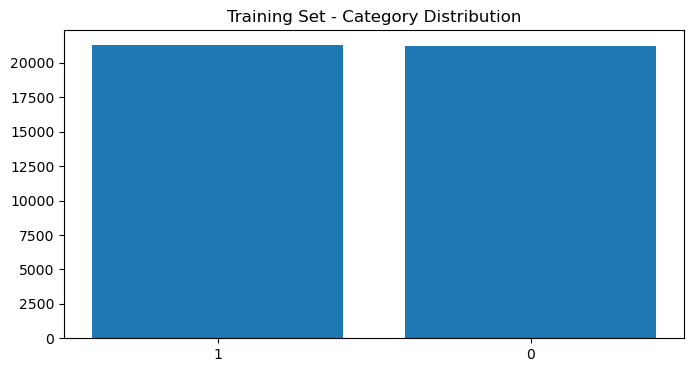

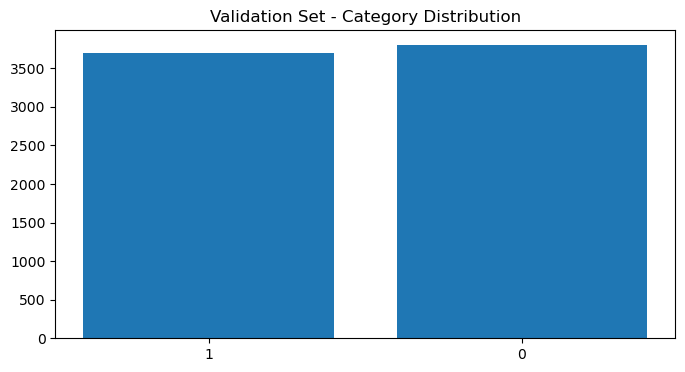

In [54]:
# Split the dataset into train and validation sets

TRAIN_TEST_SPLIT = 0.15

total_samples = df.shape[0]
n_val = int(TRAIN_TEST_SPLIT * total_samples)
n_train = total_samples - n_val

cat_dict = df['sentiment_enc'].value_counts().to_dict()

random_i = random.sample(range(total_samples), total_samples)
train_x = review_set[random_i[:n_train]]
train_y = sentiment_set[random_i[:n_train]]
val_x = review_set[random_i[n_train: n_train + n_val]]
val_y = sentiment_set[random_i[n_train: n_train + n_val]]

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_y.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_y.shape))

# Let's look at the distribution of categories in both sets
categories, ccount = np.unique(train_y, return_counts=True)
plt.figure(figsize=(6, 3))
plt.title("Training Set - Category Distribution")
plt.xticks(range(len(categories)), cat_dict.keys())
plt.bar(categories, ccount, align='center')
plt.show()

categories, ccount = np.unique(val_y, return_counts=True)
plt.figure(figsize=(8,))
plt.title("Validation Set - Category Distribution")
plt.xticks(range(len(categories)), cat_dict.keys())
plt.bar(categories, ccount, align='center')
plt.show()

n_categories = len(categories)

## 3. Create tf.data.Datasets for Training and Evaluation

In [13]:
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
    valid_data = tf.data.Dataset.from_tensor_slices((val_x, val_y))

    for text, label in train_data.take(1):
        print(text, label)

tf.Tensor(b"Totally different, with loads of understatement and black comedy, this is a film few get to see, but those who do will remember it. This movie creates its own universe, and is fascinating in every way. What it is about? Estrangement, I believe. Probably up to the viewer, but I found that this movie tries to say something about the coldness and emptiness behind all the designer furniture and perfect facades. Don't know if I'm right. But this movie really got to me. See it. I really hope the team behind this movie makes more movies, and that they will continue to do so in their own, some kinda weird style. And I forgot: The Casting here i superb, with Trond Fausa Aurv\xc3\xa5g being perfect in the role as the Bothersome Man, who doesn't understand where he is, what he is doing and why. The acknowledgment of not understanding the purpose of life (in the city), is what makes him bothersome. All the others do as they are told, and pretend (?) to be happy. This movie is a good an

2024-11-09 06:26:02.694640: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 4. Download a Pre-trained BERT Model from TensorFlow Hub

In [12]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1]  # Label categories
max_seq_length = 128  # maximum length of (token) input sequences
train_batch_size = 32


# Get BERT layer and tokenizer:
# More details here: https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-l-12-h-768-a-12/2
bert_layer = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-l-12-h-768-a-12/2", trainable=True)

I0000 00:00:1731133558.596173    6072 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14785 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0


In [14]:
from models.official.nlp.tools import tokenization

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [15]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [16]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

## 5. Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [17]:
# This provides a function to convert row to input features and label
from models.official.nlp.data import classifier_data_lib

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
    example = classifier_data_lib.InputExample(guid=None, text_a=text.numpy(), text_b=None, label=label.numpy())
    feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## 6. Wrap a Python Function into a TensorFlow op for Eager Execution

In [18]:
def to_feature_map(text, label):
    input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                                             Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])

    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }

    return (x, label_id)

## 7. Create a TensorFlow Input Pipeline with `tf.data`

In [19]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
                        .shuffle(1000)
                        .batch(32, drop_remainder=True)
                        .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                        .batch(32, drop_remainder=True)
                        .prefetch(tf.data.experimental.AUTOTUNE))

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [20]:
# train data spec
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [21]:
# valid data spec
valid_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## 8. Add a Classification Head to the BERT Layer

In [22]:
# Structuring the model
def create_model():
    input_words_ids = tf.keras.layers.Input(shape=(max_seq_length), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(max_seq_length), dtype=tf.int32, name="input_type_ids")
    # inputs={
    #     'input_word_ids': input_words_ids,
    #     'input_mask': input_mask,
    #     'input_type_ids': input_type_ids
    # }
    inputs = [input_words_ids, input_mask, input_type_ids]

    # output = bert_layer(inputs)
    # pooled_output, sequence_output = output['pooled_output'], output['sequence_output']
    pooled_output, sequence_output = bert_layer(inputs)

    drop = tf.keras.layers.Dropout(0.4)(pooled_output)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(drop)

    model = tf.keras.Model(
      inputs={
          'input_word_ids': input_words_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs=output
    )
    return model

## 9. Fine-Tune BERT for Text Classification

In [23]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=2e-5), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                              

In [ ]:
# !pip install pydot graphviz
# tf.keras.utils.plot_model(model=model, show_shapes=True)

In [25]:
# Train model
epochs = 4
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose="auto")

Epoch 1/4
1328/1328 [==============================] - 398s 286ms/step - loss: 0.3192 - binary_accuracy: 0.8574 - val_loss: 0.2706 - val_binary_accuracy: 0.8878
Epoch 2/4
1328/1328 [==============================] - 384s 287ms/step - loss: 0.1925 - binary_accuracy: 0.9233 - val_loss: 0.2962 - val_binary_accuracy: 0.8902
Epoch 3/4
1328/1328 [==============================] - 384s 287ms/step - loss: 0.1067 - binary_accuracy: 0.9610 - val_loss: 0.4110 - val_binary_accuracy: 0.8769
Epoch 4/4
1328/1328 [==============================] - 385s 287ms/step - loss: 0.0551 - binary_accuracy: 0.9806 - val_loss: 0.4763 - val_binary_accuracy: 0.8929


## 10. Evaluate the BERT Text Classification Model

In [26]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_' + metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_' + metric])
  plt.show()

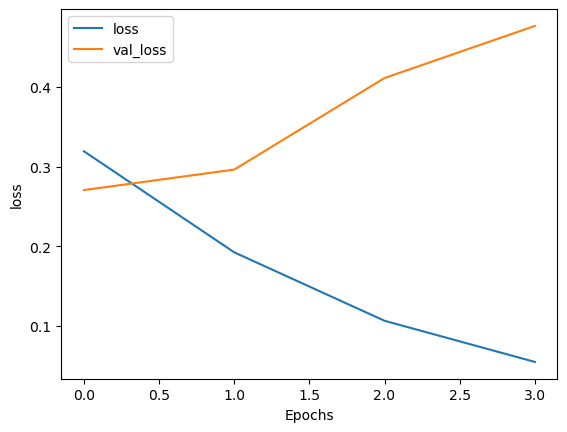

In [27]:
plot_graphs(history, 'loss')

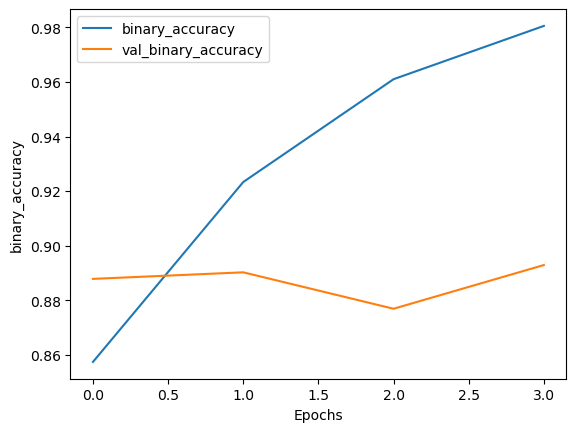

In [28]:
plot_graphs(history, 'binary_accuracy')

In [52]:
sample_example = [
                    "This is a bad movie", 
                    "What a wonderful, insightful movie!", 
                    "The movie had its ups and downs, it was mostly good", 
                    "The movie had its ups and downs, mostly downs"  # Notice how the model predicts the wrong sentiment here, this could be due to the threshold
                 ]
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0] * len(sample_example)))
test_data = test_data.map(to_feature_map).batch(1)
preds = model.predict(test_data)

threshold = 0.5  # Between 0 and 1
for pred in preds:
    print(pred, "Negative" if pred < threshold else "Positive")

4/4 [==============================] - 0s 9ms/step
[0.00197781] Negative
[0.9996357] Positive
[0.9431901] Positive
[0.8440033] Positive


## 11. Next Steps
1. Experiment with the hyperparameters
   - The model seems to be overfitting on the dataset
   - Its training accuracy and loss improve but the validation results get progressively worse - try reducing the epochs or early stopping
2. Try tuning the dropouts to see if the model does better
3. Experiment with the threshold
5. Upgrade tensorflow and keras for compatibility
6. Upgrade the BERT model from v2 to v4